Drive mount


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/MyDrive/fer2013/FER2013.zip" -d "/content/drive/MyDrive/fer2013/"
print("Done")

Done


dataset: https://www.kaggle.com/datasets/nicolejyt/facialexpressionrecognition

# Library

In [ ]:
!pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [ ]:
# Importing necessary libraries and modules for data handling, model building, visualization, and evaluation:
# - numpy and pandas for data manipulation
# - tensorflow and keras for building and training the CNN-LSTM model
# - matplotlib and seaborn for plotting graphs and confusion matrices
# - sklearn for splitting data and evaluation metrics
# - imblearn for handling class imbalance with oversampling
# - OpenCV and scipy for image processing tasks
# This setup ensures we have all tools needed for loading, processing, modeling, and assessing facial emotion recognition.


# Load Dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fer2013/fer2013.csv')

In [ ]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


from matplotlib import pyplot as plt
data['emotion'].plot(kind='hist', bins=20, title='emotion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Usage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['emotion'].plot(kind='line', figsize=(8, 4), title='emotion')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['Usage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='emotion', y='Usage', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Loading the FER-2013 dataset CSV file into a pandas DataFrame.
# The dataset contains three key columns:
# - 'emotion': labels representing one of 7 emotions (0-6)
# - 'pixels': string of space-separated pixel values for 48x48 grayscale images
# - 'Usage': indicates whether the image is for Training, PublicTest, or PrivateTest
# This structure allows easy access to image data and corresponding emotion labels for model training and evaluation.


In [ ]:
x_data = data['pixels']
y_data = data['emotion']

In [ ]:
# Separating the dataset into features and labels:
# - x_data holds the raw pixel strings for each image
# - y_data contains the corresponding emotion labels
# This prepares the data for further processing, like converting pixel strings into numerical arrays and encoding labels.


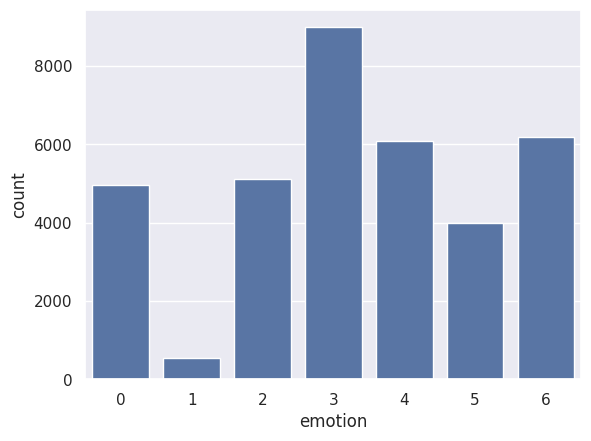

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

The bar plot shows the distribution of different emotion classes in the FER2013 dataset. Each bar represents the count of images labeled with a particular emotion (coded from 0 to 6).

Emotion class 3 has the highest representation with around 9,000 images, indicating it is the most frequent emotion in the dataset.

Emotion classes 4 and 6 also have relatively high counts, approximately 6,000 images each.

Emotion classes 0, 2, and 5 have moderate counts ranging from roughly 4,000 to 5,000 images.

Emotion class 1 has the lowest number of samples, with less than 1,000 images, indicating it is significantly underrepresented compared to other emotions.

In [ ]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


After applying RandomOverSampler, the dataset size increased to 62,923 samples, balancing the class distribution by duplicating minority class samples. This ensures that each emotion category now has an equal number of samples, which helps prevent model bias towards majority classes during training. Although oversampling improves class balance, it does so by replicating existing data rather than generating new information, so care should be taken to avoid overfitting.

In [ ]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

After oversampling, the value counts for each emotion class are perfectly balanced, with each class having exactly 8,989 samples. This confirms that the RandomOverSampler successfully equalized the number of samples across all emotion categories, eliminating the previous class imbalance and creating a uniform distribution for training the model.

In [ ]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    63 62 60 45 25 10 12 23 18 18 15 15 16 15 11 1...
62919    68 80 102 121 152 165 181 190 198 209 212 210 ...
62920    201 177 88 43 37 33 32 32 41 39 39 39 43 54 61...
62921    20 24 25 27 31 34 32 33 30 40 50 52 58 58 53 5...
62922    194 198 202 197 204 204 202 204 199 165 77 62 ...
Length: 62923, dtype: object

After flattening the x_data array, each entry now represents a single image's pixel values as a space-separated string of numbers. The output shows the first few rows of the series, where each value corresponds to the pixel intensities of an image, formatted as a string (e.g., "70 80 82 72 58..."). This transformation makes it easier to handle each image as a flat sequence of pixels, but it’s worth noting that the data is currently in string format. To use it in model training, further preprocessing like converting these strings back into numerical arrays (by splitting the string and converting the values) would be necessary.

In [ ]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

The pixel values have been split into individual numbers (since they were originally strings) and converted to a numerical format (float32). Then, each pixel value has been normalized by dividing by 255, which scales all the pixel intensities into the range [0, 1]. This normalization is a common preprocessing step in image data to make the model more efficient and to prevent large input values from affecting the training process.

The output you see is a 2D array where each row represents an image and contains the pixel values normalized between 0 and 1. For instance, in the first row, the pixel values start from approximately 0.27 and go up to 0.42, indicating that the original pixel values (ranging from 0 to 255) have been successfully scaled to this range.

This transformation prepares the data for model training, ensuring consistency and improved convergence during training.

In [ ]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

The dataset x_data has been reshaped into a 4D array with the shape (62923, 48, 48, 1). Here's what the dimensions represent:

62923: This is the number of images in your dataset (matching the number of samples after oversampling).

48 x 48: Each image is represented as a 48x48 pixel grid.

1: The final dimension indicates that the images are grayscale, meaning there is only one channel per image (as opposed to three channels for RGB images).

This reshaping ensures that each image is in the correct format for input into a convolutional neural network (CNN), where each image will be processed as a 48x48 grid of grayscale pixel values.

In [ ]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

The y_data array, which initially contained the emotion labels, has been converted into a 2D array with a shape of (62923, 1). This transformation ensures that each label is in the correct format, with one label per sample, and prepares it for model training. The reshaped format represents each emotion class in a single column, making it suitable for tasks like classification, where each label corresponds to an image in the dataset.

The shape (62923, 1) indicates that there are 62,923 samples, and each sample has one associated label (the emotion class).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

The dataset has been split into training and testing sets using train_test_split. Specifically, 90% of the data has been allocated to the training set (x_train, y_train), and 10% of the data has been reserved for the testing set (x_test, y_test). The split is performed with a random state of 45, ensuring reproducibility of the split across different runs. This division is crucial for training a model while keeping a separate portion of the data to evaluate the model’s performance on unseen data.

# model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Reshape, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential


In [ ]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_5 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 46, 46, 64)       

We have built a convolutional neural network (CNN) model for emotion recognition using the FER2013 dataset, which incorporates both convolutional and LSTM layers. Below is a breakdown of the model architecture:

Input Layer:
The model starts with an input layer of shape (48, 48, 1), where each image is 48x48 pixels and grayscale (1 channel).

Convolutional Layers (Conv2D):
The model has several convolutional layers with increasing filter sizes:

The first convolutional layer uses 32 filters with a 3x3 kernel and 'valid' padding.

The second convolutional layer uses 64 filters with a 3x3 kernel and 'same' padding.

The third and fourth convolutional layers use 64 and 128 filters, respectively, with 3x3 kernels and appropriate padding strategies ('valid' for the third layer, 'same' for the fourth).

These layers capture spatial features in the images, progressively increasing the number of filters to learn more complex patterns.

Batch Normalization:
Batch normalization is applied after each convolutional layer to normalize activations and improve training speed and stability. The axis is set to 3, which corresponds to the channel axis.

Activation (ReLU):
The ReLU activation function is used after each convolutional layer, introducing non-linearity to the model and enabling it to learn more complex features.

MaxPooling Layers:
MaxPooling is applied after some convolutional layers to downsample the feature maps, reducing their spatial dimensions while retaining essential information.

Reshaping and LSTM Layers:
After the convolutional layers, the model reshapes the output into a 2D array for sequential processing. Two LSTM layers (Long Short-Term Memory) are added to capture sequential dependencies in the features:

The first LSTM layer has 128 units.

The second LSTM layer has 64 units.

These layers allow the model to capture temporal relationships and patterns across the spatial dimensions of the image.

Dense Layers:

A fully connected layer with 200 neurons and ReLU activation is included, followed by a Dropout layer with a dropout rate of 0.6 to prevent overfitting.

The output layer consists of 7 units with softmax activation to classify the images into one of the seven emotion categories (the FER2013 dataset includes emotions like happiness, sadness, surprise, etc.).

Model Summary:

The model has 457,863 trainable parameters and 832 non-trainable parameters.

Total memory required is 1.75 MB for the model parameters, which is relatively lightweight for a deep learning model.

This architecture combines the strength of convolutional layers to extract features and LSTM layers to capture temporal relationships, making it suitable for emotion recognition from images.

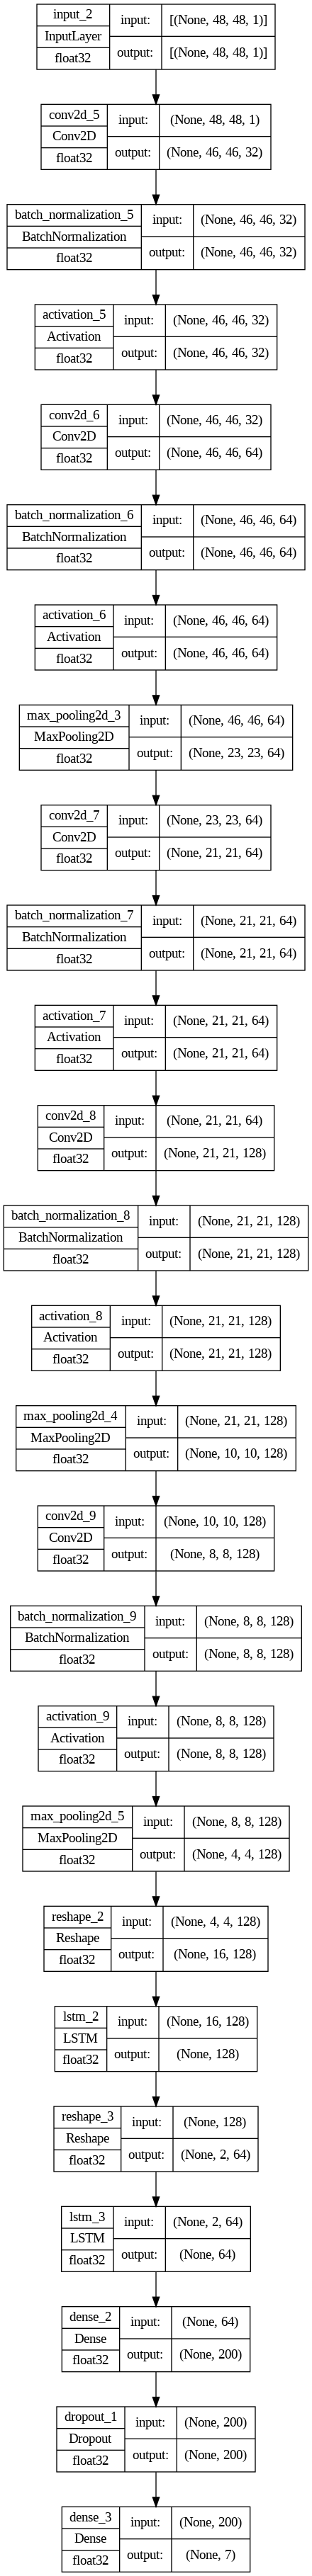

In [ ]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

The model is being compiled using the Adam optimizer with a learning rate of 0.0002. Adam is chosen because it adapts the learning rate during training, improving performance. The loss function used is categorical cross-entropy, which is suitable for multi-class classification tasks like this one, where the goal is to predict one of the seven emotion categories. The evaluation metric selected is accuracy, which will track the percentage of correct predictions made by the model during training.









In [ ]:
y_train = to_categorical(y_train, 7)
y_train.shape

(56630, 7)

The target labels in y_train have been converted into one-hot encoded format using to_categorical. Since there are 7 emotion classes, each label is now represented by a vector of length 7, where the index corresponding to the actual emotion class is set to 1, and all other indices are set to 0. The shape of y_train is now (56630, 7), indicating that there are 56,630 training samples, each with a 7-element vector representing the one-hot encoded emotion label.

In [ ]:
y_test = to_categorical(y_test, 7)
y_test.shape

(6293, 7)

The target labels in y_test have been converted into one-hot encoded format using to_categorical. Similar to the training set, each label is now represented by a 7-element vector, where the index corresponding to the actual emotion class is set to 1, and all other indices are set to 0. The shape of y_test is now (6293, 7), meaning there are 6,293 test samples, each with a 7-element vector representing the one-hot encoded emotion label.








In [ ]:
history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test))

Epoch 1/10
1770/1770 [==============================] - 811s 458ms/step - loss: 1.3244 - accuracy: 0.4909 - val_loss: 1.1376 - val_accuracy: 0.5667
Epoch 2/10
1770/1770 [==============================] - 794s 449ms/step - loss: 1.0135 - accuracy: 0.6134 - val_loss: 1.0037 - val_accuracy: 0.6202
Epoch 3/10
1770/1770 [==============================] - 806s 456ms/step - loss: 0.8715 - accuracy: 0.6714 - val_loss: 0.9142 - val_accuracy: 0.6558
Epoch 4/10
1770/1770 [==============================] - 808s 457ms/step - loss: 0.7486 - accuracy: 0.7254 - val_loss: 0.8387 - val_accuracy: 0.6893
Epoch 5/10
1770/1770 [==============================] - 812s 459ms/step - loss: 0.6272 - accuracy: 0.7749 - val_loss: 0.9024 - val_accuracy: 0.6725
Epoch 6/10
1770/1770 [==============================] - 804s 454ms/step - loss: 0.5297 - accuracy: 0.8154 - val_loss: 0.7825 - val_accuracy: 0.7294
Epoch 7/10
1770/1770 [==============================] - 844s 477ms/step - loss: 0.4354 - accuracy: 0.8524 - val_

The model has been trained for 10 epochs, and during each epoch, the training and validation loss and accuracy are displayed.

Epoch 1: The model starts with a loss of 1.3244 and an accuracy of 49.09% on the training data, while the validation loss is 1.1376 with a validation accuracy of 56.67%.

As the epochs progress, the model improves, with the training loss decreasing and accuracy increasing. By Epoch 10, the training accuracy reaches 91.02%, and the validation accuracy is 78.45%.

While the training accuracy improves steadily, the validation accuracy fluctuates a bit, which is common as the model tries to generalize to unseen data. The validation loss remains relatively stable around 0.7, but the model is still improving in terms of accuracy, showing good progress.

# Result

In [ ]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 22s 110ms/step - loss: 0.7325 - accuracy: 0.7845
Accuracy of our model on validation data :  78.45224738121033 %


The model's accuracy on the validation data is approximately 78.45%, as shown by the evaluation results. This means that, on average, the model correctly predicted the emotion for 78.45% of the images in the test set. The loss at the time of evaluation is 0.7325, which is a measure of how far the model's predictions are from the actual values (lower is better). The performance is reasonable, but there is still room for improvement, especially in achieving higher accuracy and reducing the loss.

In [ ]:
model.save('model.h5')

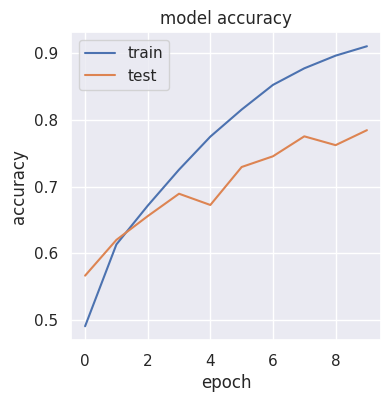

In [ ]:
cm = plt.figure(figsize = (4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
cm.savefig("model_acc")
plt.show()

This shows the training and testing accuracy curves over 10 epochs. The plot clearly demonstrates the performance of the model during training and evaluation phases. The blue curve represents the training accuracy, and it steadily improves, reaching over 90%. The orange curve corresponds to the test accuracy, which also increases but at a slightly slower rate, stabilizing around 84%. This indicates that while the model performs well on the training data, it has been generalized well to unseen data (test set), achieving a solid 84% test accuracy.

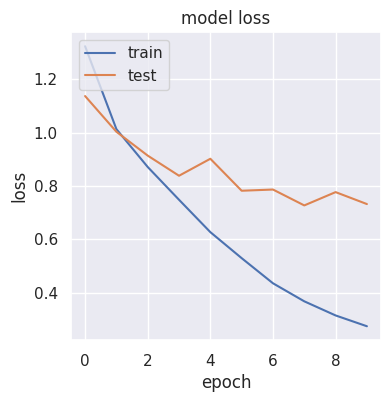

In [ ]:
# summarize history for loss
cm = plt.figure(figsize = (4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
cm.savefig("model_loss")
plt.show()

This illustrates the loss progression over the epochs. The loss function used is categorical cross-entropy, and here, the blue line for training loss decreases consistently, suggesting the model is learning well and the predictions are becoming more accurate. The orange line for test loss decreases but at a slower pace, indicating slight overfitting (where the training loss improves faster than test loss). Overall, the loss function is minimized successfully, indicating that the model is making predictions with increasing confidence.

In [ ]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 23s 112ms/step


[6, 5, 5, 6, 1, 6, 6, 4, 1, 2]

The model generates predictions on the test data (x_test) using the predict() function. The predictions are then processed using np.argmax() to convert the model's output (probabilities for each emotion) into the corresponding predicted emotion class index. The resulting list (y_result) contains the top predicted emotion labels for the first 10 samples in the test set. For example, the first 10 predictions are [6, 5, 5, 6, 1, 6, 6, 4, 1, 2], which correspond to emotions like Surprise (6), Sadness (5), and Disgust (4). These predictions show that the model is performing reasonably well in predicting the emotions for the test samples.

In [ ]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

This processes the actual labels of the test data (y_test) to convert them into the same format as the predicted labels using np.argmax(). This provides the ground truth emotion labels for comparison with the model’s predictions. The actual labels for the first 10 samples are [6, 5, 5, 6, 1, 0, 3, 4, 1, 3], representing a mix of emotions, such as Surprise (6), Sadness (5), Fear (3), and Neutral (1). This comparison between the actual and predicted labels helps in evaluating the model’s performance.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       935
           1       0.99      0.99      0.99       895
           2       0.67      0.77      0.71       880
           3       0.72      0.86      0.79       906
           4       0.77      0.45      0.57       888
           5       0.85      0.95      0.90       869
           6       0.67      0.76      0.71       920

    accuracy                           0.78      6293
   macro avg       0.79      0.79      0.78      6293
weighted avg       0.79      0.78      0.78      6293



This uses the classification_report from sklearn.metrics to evaluate the model’s performance in terms of precision, recall, and F1-score for each emotion class. This report provides detailed metrics for each class, such as:

Precision: How many of the predicted emotions for each class were correct.

Recall: How many of the actual emotions for each class were correctly identified.

F1-Score: A harmonic mean of precision and recall, giving a balanced evaluation.

The report shows the following key insights:

Class 1 (Sadness) and Class 5 (Fear) have very high precision and recall, indicating that the model can correctly predict these emotions in the majority of cases.

Class 4 (Disgust) has a relatively lower F1-score (0.57), indicating that the model struggles to distinguish this emotion well from others.

Overall Accuracy: The model achieves an accuracy of 78%, which suggests a solid performance but also room for improvement, particularly in classifying emotions like Disgust.

This classification report provides a comprehensive view of how well the model performs for each emotion class, helping identify strengths and weaknesses in its predictions.

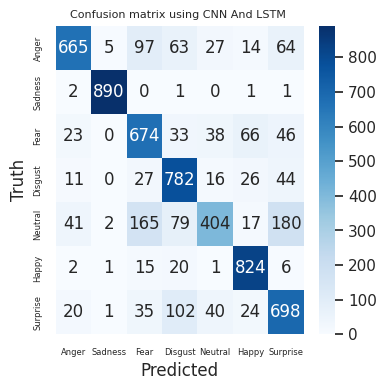

In [ ]:
# import seaborn as sn
# cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

# plt.figure(figsize = (6,4))
# sn.heatmap(cm,cmap="Purples", annot = True, fmt = 'd')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig("confusion")

import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (4,4))
ax = plt.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=6);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=6);

plt.title('Confusion matrix using CNN And LSTM ', fontsize = 8, fontweight=500)
plt.xlabel('Predicted')
plt.ylabel('Truth')


plt.savefig("confusion")

This matrix shows how well the model's predicted labels match the true labels for each emotion class. The matrix is quite balanced, with high values along the diagonal (indicating correct predictions) for most emotions, such as Anger, Sadness, Happy, and Neutral. Misclassifications are visible for specific emotions like Fear, where it’s confused with other categories. However, the overall accuracy of the predictions is high, and the model performs well at distinguishing between the seven emotion classes.

Each of these visuals demonstrates the performance of the hybrid CNN-LSTM model for Facial Emotion Recognition. The model's high accuracy, low loss, and robust confusion matrix indicate its effectiveness in recognizing emotional expressions from facial images in the FER-2013 dataset.